In [ ]:

import pickle
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import joblib



In [ ]:
demand = pd.read_csv("demand_hourly.csv")
df = demand.sort_values(by=['start_time_year', 'start_time_month',
                            'start_time_day', 'start_time_hour'])
df = df.drop(columns=['Unnamed: 0', 'duration_sec']).reset_index(drop=True)

standard_stations = pd.read_csv("stations_with_clusters.csv")
weather_data = pd.read_csv("weather_data.csv")

df = df.merge(standard_stations[['station_name', 'clusters']].rename(columns={
    "station_name":'start_station_name'}), on=["start_station_name"])

df = df[df.groupby('start_station_name')['start_station_name'].transform('size') >= 1000]

latest_trips = df.groupby('start_station_name').nth(-1)
earliest_trips = df.groupby('start_station_name').nth(0)


recently_operational_stations = latest_trips[(latest_trips['start_time_year'] == 2022) &
                                             (latest_trips['start_time_month'] >= 8)].index

stations_operational_since_2021 = earliest_trips[(earliest_trips['start_time_year'] == 2021)].index
df = df[df['start_station_name'].isin(stations_operational_since_2021)].reset_index(drop=True)

column_name = "start_time"
conversion_dict_daily = dict(year= df[f'{column_name}_year'],
                           month=df[f'{column_name}_month'],
                           day=  df[f'{column_name}_day'],
                           hour=  df[f'{column_name}_hour']
                        )
df['time'] = pd.to_datetime(conversion_dict_daily).astype(str)

df = df.merge(weather_data[['temp', 'dwpt', "rhum", "prcp", "wdir", "wspd", "pres", "coco", "centroid", 'time']].rename(columns={
    "centroid":"clusters"
}), on=['clusters', "time"])

df.loc[df['prcp'].isna(), 'prcp'] = 0.0
df.loc[df['pres'].isna(), 'pres'] = df['pres'].median()
df.loc[df['coco'].isna(), 'coco'] = df['coco'].mode()[0]

In [ ]:
def add_lags(df, target, identifier):
    df_res = pd.DataFrame()
    print(target)
    for ii in df[identifier].unique():
        df_current = df[df["start_station_name"]==ii]
        df_current.index = df_current['time']
        df_current.index = pd.to_datetime(df_current.index)
        target_map = df_current[target].to_dict()
        df_current[f"{target}_lag_1_h"] = (df_current.index - pd.Timedelta('1 hours')).map(target_map)
        df_current[f"{target}_lag_2_h"] = (df_current.index - pd.Timedelta('2 hours')).map(target_map)
        df_current[f"{target}_lag_24_h"] = (df_current.index - pd.Timedelta('24 hours')).map(target_map)
        if target == "demand":
            df_current[f"{target}_lag_1_h"] = df_current[f"{target}_lag_1_h"].fillna(0)
            df_current[f"{target}_lag_2_h"] = df_current[f"{target}_lag_2_h"].fillna(0)
            df_current[f"{target}_lag_24_h"] = df_current[f"{target}_lag_24_h"].fillna(0)
        else:
            df_current[f"{target}_lag_1_h"] = df_current[f"{target}_lag_1_h"].interpolate().fillna(0)
            df_current[f"{target}_lag_2_h"] = df_current[f"{target}_lag_2_h"].interpolate().fillna(0)
            df_current[f"{target}_lag_24_h"] = df_current[f"{target}_lag_24_h"].interpolate().fillna(0)
        df_res = df_res.append(df_current)
    return df_res

In [ ]:
df = add_lags(df, "demand", identifier='start_station_name')
df = add_lags(df, "temp", identifier='start_station_name')
df = add_lags(df, "prcp", identifier='start_station_name')
df = add_lags(df, "rhum", identifier='start_station_name')
df = add_lags(df, "wspd", identifier='start_station_name')

df = df.sort_values(by=['start_time_year', 'start_time_month',
                        'start_time_day', 'start_time_hour']).drop(
    columns=['time']).reset_index(drop=True)

demand


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

temp


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

prcp
rhum
wspd


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949664 entries, 0 to 1949663
Data columns (total 34 columns):
 #   Column                Dtype  
---  ------                -----  
 0   start_station_name    object 
 1   start_time_year       int64  
 2   start_time_month      int64  
 3   start_time_day        int64  
 4   start_time_hour       int64  
 5   demand                int64  
 6   start_time_week       int64  
 7   start_time_quarter    int64  
 8   start_time_dayofweek  int64  
 9   is_holiday            bool   
 10  clusters              int64  
 11  temp                  float64
 12  dwpt                  float64
 13  rhum                  float64
 14  prcp                  float64
 15  wdir                  float64
 16  wspd                  float64
 17  pres                  float64
 18  coco                  float64
 19  demand_lag_1_h        float64
 20  demand_lag_2_h        float64
 21  demand_lag_24_h       float64
 22  temp_lag_1_h          float64
 23  temp_la

In [ ]:
for i in df.columns:
    if 'lag' in i:
        print((df[(df['start_station_name'] == "1st St at Folsom St")][i].interpolate().isna()))

0          False
116        False
160        False
671        False
938        False
           ...  
1949302    False
1949351    False
1949388    False
1949546    False
1949608    False
Name: demand_lag_1_h, Length: 9531, dtype: bool
0          False
116        False
160        False
671        False
938        False
           ...  
1949302    False
1949351    False
1949388    False
1949546    False
1949608    False
Name: demand_lag_2_h, Length: 9531, dtype: bool
0          False
116        False
160        False
671        False
938        False
           ...  
1949302    False
1949351    False
1949388    False
1949546    False
1949608    False
Name: demand_lag_24_h, Length: 9531, dtype: bool
0          False
116        False
160        False
671        False
938        False
           ...  
1949302    False
1949351    False
1949388    False
1949546    False
1949608    False
Name: temp_lag_1_h, Length: 9531, dtype: bool
0          False
116        False
160        False
671       

In [ ]:
for i in df.columns:
    print(i)
    print(sum(df[i].isna()))

start_station_name
0
start_time_year
0
start_time_month
0
start_time_day
0
start_time_hour
0
demand
0
start_time_week
0
start_time_quarter
0
start_time_dayofweek
0
is_holiday
0
clusters
0
temp
0
dwpt
0
rhum
0
prcp
0
wdir
0
wspd
0
pres
0
coco
0
demand_lag_1_h
0
demand_lag_2_h
0
demand_lag_24_h
0
temp_lag_1_h
0
temp_lag_2_h
0
temp_lag_24_h
0
prcp_lag_1_h
0
prcp_lag_2_h
0
prcp_lag_24_h
0
rhum_lag_1_h
0
rhum_lag_2_h
0
rhum_lag_24_h
0
wspd_lag_1_h
0
wspd_lag_2_h
0
wspd_lag_24_h
0


In [ ]:
del demand

In [ ]:
df.tail()

,start_station_name,start_time_year,start_time_month,start_time_day,start_time_hour,demand,start_time_week,start_time_quarter,start_time_dayofweek,is_holiday,...,temp_lag_24_h,prcp_lag_1_h,prcp_lag_2_h,prcp_lag_24_h,rhum_lag_1_h,rhum_lag_2_h,rhum_lag_24_h,wspd_lag_1_h,wspd_lag_2_h,wspd_lag_24_h
1949659,North Point St at Grant Ave,2022,12,31,23,2,52,4,5,True,...,11.4125,13.90,0.0,0.9375,89.0,83.714286,87.5,24.100000,5.4,15.3625
1949660,North Point St at Powell St,2022,12,31,23,4,52,4,5,True,...,15.3000,1.35,7.6,0.4000,69.5,93.000000,75.5,7.400000,42.5,27.0000
1949661,Telegraph Ave at 49th St,2022,12,31,23,1,52,4,5,True,...,15.6000,0.30,0.0,0.0000,74.0,57.000000,78.0,18.400000,24.1,7.6000
1949662,Almaden Blvd at San Fernando St,2022,12,31,23,1,52,4,5,True,...,18.3000,0.00,0.0,0.0000,79.0,86.000000,39.0,4.000000,5.4,14.8000
1949663,San Pedro Square,2022,12,31,23,1,52,4,5,True,...,17.0000,0.00,0.0,0.0000,83.0,66.529412,75.0,5.127273,14.8,22.0000


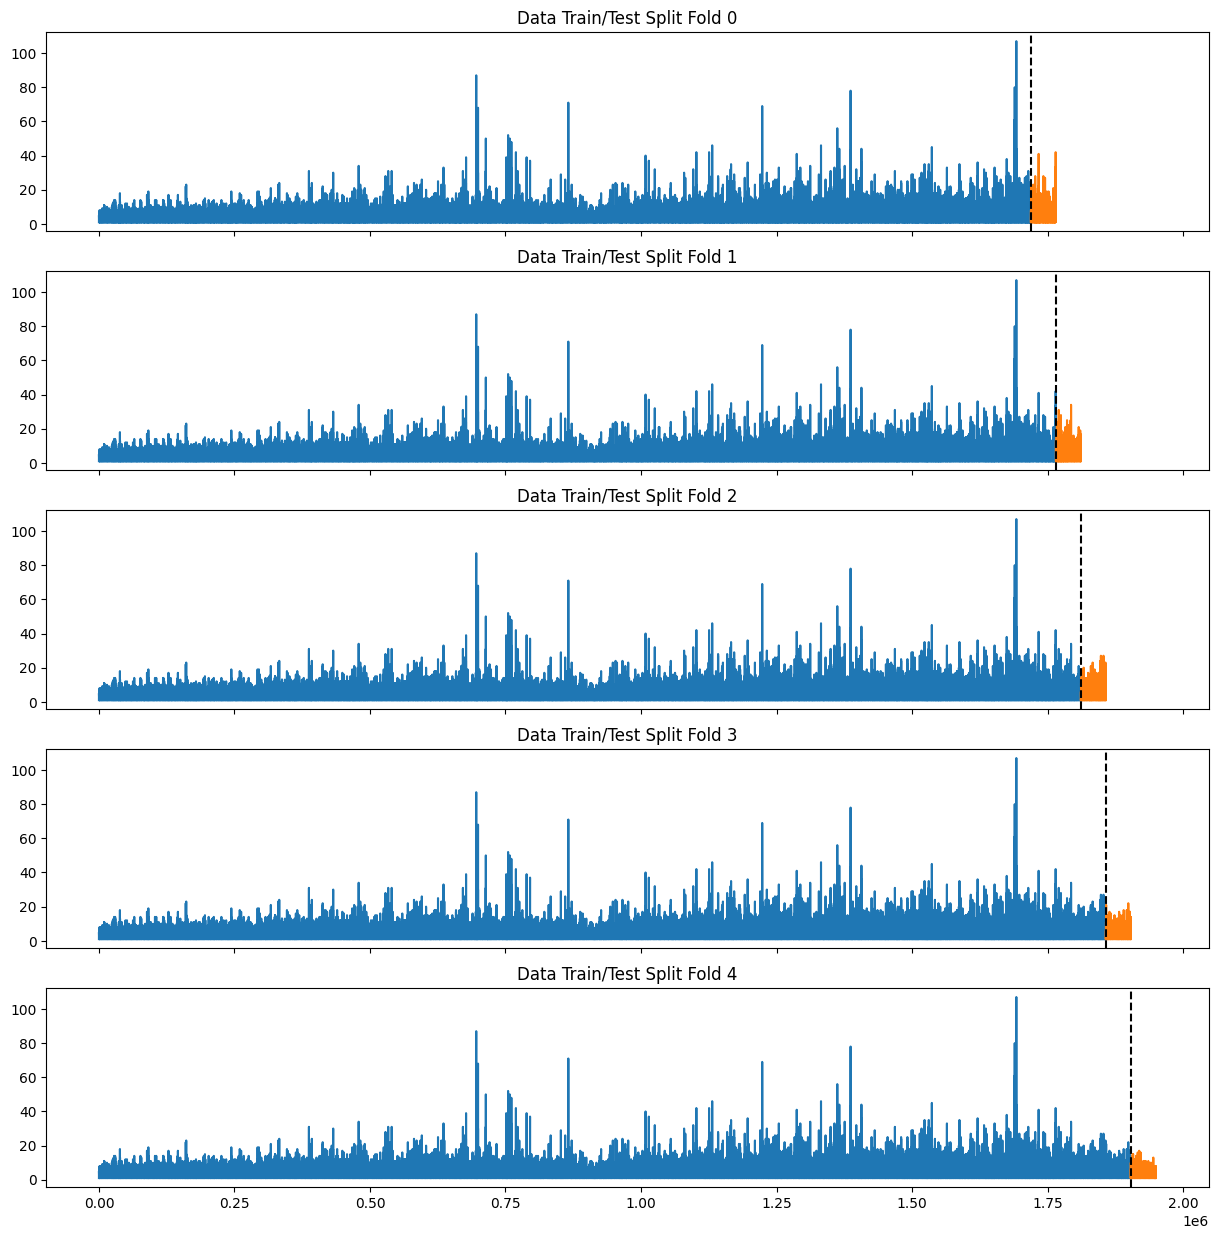

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*5*df['start_station_name'].nunique(), gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['demand'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['demand'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*5*df['start_station_name'].nunique(), gap=24)
df = df.sort_index()

fold = 0
preds = pd.DataFrame()
rmse = []
mape = []
le = preprocessing.LabelEncoder()
scaler = MinMaxScaler(feature_range=(1, 2))
SCALER_FEATURES = ["start_time_year", "start_time_month",
                   "start_time_day", "start_time_hour",
                   "start_time_week", "start_time_quarter",
                   "start_time_dayofweek",
                   "temp", "dwpt", "rhum", "prcp", "wdir",
                   "wspd", "pres","coco",
                   "demand_lag_1_h", "demand_lag_2_h",
                   "demand_lag_24_h", "temp_lag_1_h",
                   "temp_lag_2_h", "temp_lag_24_h",
                   "prcp_lag_1_h", "prcp_lag_2_h",
                   "prcp_lag_24_h", "rhum_lag_1_h",
                   "rhum_lag_2_h", "rhum_lag_24_h", "wspd_lag_1_h",
                   "wspd_lag_2_h","wspd_lag_24_h"]
target_scaler = MinMaxScaler(feature_range=(1, 2))
df[SCALER_FEATURES] = scaler.fit_transform(df[SCALER_FEATURES])
df[['demand']] = target_scaler.fit_transform(df[['demand']])
df['start_station_name'] = le.fit_transform(df['start_station_name'])
df['is_holiday'] = df['is_holiday'].astype(int)


In [ ]:
24*5*df['start_station_name'].nunique()

46080

In [ ]:
24*10*df['start_station_name'].nunique()

92160

In [ ]:

for train_idx, val_idx in tss.split(df):

    train = df.iloc[train_idx]
    test = df.iloc[val_idx]


    FEATURES = ["start_station_name",
                "start_time_year",
                "start_time_month",
                "start_time_day",
                "start_time_hour",
                "start_time_week",
                "start_time_quarter",
                "start_time_dayofweek",
                "is_holiday",
                "clusters",
                "temp",
                "dwpt",
                "rhum",
                "prcp",
                "wdir",
                "wspd",
                "pres",
                "coco",
                "demand_lag_1_h",
                "demand_lag_2_h",
                "demand_lag_24_h",
                "temp_lag_1_h",
                "temp_lag_2_h",
                "temp_lag_24_h",
                "prcp_lag_1_h",
                "prcp_lag_2_h",
                "prcp_lag_24_h",
                "rhum_lag_1_h",
                "rhum_lag_2_h",
                "rhum_lag_24_h",
                "wspd_lag_1_h",
                "wspd_lag_2_h",
                "wspd_lag_24_h"
                ]
    TARGET = 'demand'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = RandomForestRegressor(random_state=42)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    preds_out = X_test.copy()
    preds_out['actual_demand'] = y_test
    preds_out['pred'] = y_pred
    preds = preds.append(preds_out)
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_score = mean_absolute_percentage_error(y_test, y_pred)
    rmse.append(rmse_score)
    mape.append(mape_score)
    print(rmse_score)
    print(mape_score)
    print(preds.head())
    print(preds.tail())

print(f"Mean RMSE: {np.mean(rmse)}")
print(f"Mean MAPE: {np.mean(mape)}")
del df
del X_train
del y_train
del X_test

0.014829937842398324
0.010068721568566315
         start_station_name  start_time_year  start_time_month  \
1719264                 190              2.0          1.818182   
1719265                 287              2.0          1.818182   
1719266                 383              2.0          1.818182   
1719267                 361              2.0          1.818182   
1719268                   9              2.0          1.818182   

         start_time_day  start_time_hour  start_time_week  start_time_quarter  \
1719264             1.1         1.434783             1.75                 2.0   
1719265             1.1         1.434783             1.75                 2.0   
1719266             1.1         1.434783             1.75                 2.0   
1719267             1.1         1.434783             1.75                 2.0   
1719268             1.1         1.434783             1.75                 2.0   

         start_time_dayofweek  is_holiday  clusters  ...  prcp_lag_2_h  \


0.01335314617334217
0.009372008819827152
         start_station_name  start_time_year  start_time_month  \
1719264                 190              2.0          1.818182   
1719265                 287              2.0          1.818182   
1719266                 383              2.0          1.818182   
1719267                 361              2.0          1.818182   
1719268                   9              2.0          1.818182   

         start_time_day  start_time_hour  start_time_week  start_time_quarter  \
1719264             1.1         1.434783             1.75                 2.0   
1719265             1.1         1.434783             1.75                 2.0   
1719266             1.1         1.434783             1.75                 2.0   
1719267             1.1         1.434783             1.75                 2.0   
1719268             1.1         1.434783             1.75                 2.0   

         start_time_dayofweek  is_holiday  clusters  ...  prcp_lag_2_h  \
1

0.011260492824156674
0.008454728347818742
         start_station_name  start_time_year  start_time_month  \
1719264                 190              2.0          1.818182   
1719265                 287              2.0          1.818182   
1719266                 383              2.0          1.818182   
1719267                 361              2.0          1.818182   
1719268                   9              2.0          1.818182   

         start_time_day  start_time_hour  start_time_week  start_time_quarter  \
1719264             1.1         1.434783             1.75                 2.0   
1719265             1.1         1.434783             1.75                 2.0   
1719266             1.1         1.434783             1.75                 2.0   
1719267             1.1         1.434783             1.75                 2.0   
1719268             1.1         1.434783             1.75                 2.0   

         start_time_dayofweek  is_holiday  clusters  ...  prcp_lag_2_h  \


In [ ]:
suf = "_dec_2022_weather_lags"

#preds.to_csv(f"test_predictions{suf}.csv")
#del preds
#
#filename = f'demand_model{suf}.sav'
#joblib.dump(reg, filename)
#del reg

filename = f'target_scaler{suf}.sav'
joblib.dump(target_scaler, filename)
del target_scaler

filename = f'scaler{suf}.sav'
joblib.dump(scaler, filename)
del scaler

filename = f'label_encoder{suf}.sav'
joblib.dump(le, filename)
del le


In [ ]:
#preds['demand'] = preds['actual_demand']
#preds[SCALER_FEATURES] = scaler.inverse_transform(preds[SCALER_FEATURES])